# Make movies from LLC

In [2]:
!pip install git+https://github.com/jbusecke/xmovie.git

  Cloning https://github.com/jbusecke/xmovie.git to /tmp/pip-req-build-rz_g2rbw
  Running command git clone -q https://github.com/jbusecke/xmovie.git /tmp/pip-req-build-rz_g2rbw
  Created wheel for xmovie: filename=xmovie-0.1.0-py3-none-any.whl size=11002 sha256=3c74d6bbbf77ff696ddeec1782c6537b2408324bdd494ccb08e2ff4f0c86541a
  Stored in directory: /tmp/pip-ephem-wheel-cache-hq1j50o1/wheels/54/d4/a5/bb21f910f0c7f558485ddd343e43f65d90ed938755ed6bce25
Successfully built xmovie


In [1]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
from xmitgcm import llcreader
from matplotlib import pyplot as plt
from xmovie import Movie
import cmocean.cm as cm

In [2]:
import cmocean.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

In [3]:
#%matplotlib inline
# this needs to be commented out so that xmovie does not crash

In [4]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

In [5]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()

In [6]:
coords = cat.LLC4320_grid.to_dask()

In [7]:
u.U.attrs = {'long_name': 'Zonal Velocity (m/s)', 
            'mate': 'V', 'units':'m/s'}
v.V.attrs = {'long_name': 'Meridional Velocity (m/s)', 
            'mate': 'U', 'units':'m/s'}

In [8]:
ds = xr.merge([ u, v, sst, ssh, sss.SSS, coords])

In [9]:
ds_ll = llcreader.llcmodel.faces_dataset_to_latlon(ds, 
                metric_vector_pairs=[])

In [10]:
import xgcm
grid = xgcm.Grid(ds_ll.drop(['k', 'k_p1']), periodic='X')

In [11]:
from fastjmd95 import rho
ds_ll['SSD'] = xr.apply_ufunc(rho, 
                        ds_ll.SSS, ds_ll.SST, 0, 
                        dask='parallelized', output_dtypes=[float,]).rename('SSD')

#import gsw
#ds['Spice'] = xr.apply_ufunc(gsw.spiciness0, 
#                        ds.SSS, ds.SST,  
#                        dask='parallelized', output_dtypes=[float,]).rename('Spice')

In [12]:
sel_XC = np.logical_and(ds_ll.XC>0, ds_ll.XC<65 ) 
sel_XG = np.logical_and(ds_ll.XG>0, ds_ll.XG<65 )
sel_YC = np.logical_and(ds_ll.YC>-63, ds_ll.YC<-40 )
sel_YG = np.logical_and(ds_ll.YG>-63, ds_ll.YG<-40 )

In [13]:
XC = ds_ll.XC.where(sel_XC & sel_YC, drop=True)
YC = ds_ll.YC.where(sel_XC & sel_YC, drop=True)
XCmean = XC.mean(['j'])
YCmean = YC.mean(['i'])

Xmax = XC.max(['j'])
Xmin = XC.min(['j'])
Ymax = YC.max(['i'])
Ymin = YC.min(['i'])

In [14]:
XG = coords.XG.where(sel_XG & sel_YG, drop=True)
YG = coords.YG.where(sel_XG & sel_YG, drop=True)
XGmean = XG.mean(['j_g'])
YGmean = YG.mean(['i_g'])

## Movie of Surface Tracers

In [15]:
SSH_SO = ds_ll.Eta.where(sel_XC & sel_YC, drop=True)
SST_SO = ds_ll.SST.where(sel_XC & sel_YC, drop=True)
SSS_SO = ds_ll.SSS.where(sel_XC & sel_YC, drop=True)
SSD_SO = ds_ll.SSD.where(sel_XC & sel_YC, drop=True)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

In [16]:
ds_SO = xr.merge([SST_SO, SSS_SO, SSD_SO, SSH_SO])

In [17]:
ds_SO

<xarray.Dataset>
Dimensions:  (i: 3120, j: 1912, time: 9030)
Coordinates:
  * j        (j) int64 3733 3734 3735 3736 3737 ... 5640 5641 5642 5643 5644
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4939 4940 4941 4942 4943
    CS       (j, i) float32 dask.array<chunksize=(587, 2496), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(587, 2496), meta=np.ndarray>
    PHrefC   float32 15.4
    SN       (j, i) float32 dask.array<chunksize=(587, 2496), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(587, 2496), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(587, 2496), meta=np.ndarray>
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    drF      float32 1.14
    hFacC    (j, i) float32 dask.array<chunksize=(587, 2496), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 dask.array<chunksize=(587, 2496), meta=np.ndarray>
Data variables:
    SST      (time, j, i) float32 dask.array<chunksize=(1, 587, 2496), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 587, 2496), meta=np.ndarray>
    SSD      (time, j, i) float64 dask.array<chunksize=(1, 587, 2496), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 587, 2496), meta=np.ndarray>

### Test plots 

In [20]:
ds_SO_small = ds_SO.isel(i=slice(0,-1,4),j=slice(0,-1,4))
XC = ds_SO_small.XC
YC = ds_SO_small.YC 

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


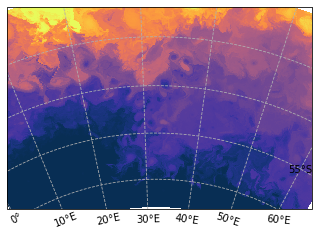

In [45]:
fig = plt.figure(figsize=(12,9))
fig.set_tight_layout(True)

ax = fig.add_subplot(2, 2, 1, projection=ccrs.SouthPolarStereo(central_longitude=32))
ax.set_extent([12, 53, -61.5, -42], crs=ccrs.PlateCarree())
    

gl = ax.gridlines(draw_labels=True, xlocs=[0,10, 20, 30, 40, 50, 60],
            ylocs = [-60, -55, -50, -45], linestyle='--',)
gl.xlabels_top = False
#gl.bottom_labels = False
#gl.left_labels = True 
#gl.right_labels = False

plt.pcolormesh(XC, YC,
    ds_SO_small.SST.isel(time=-1), vmin=-3, vmax=15,cmap=cm.thermal,transform=ccrs.PlateCarree())


/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


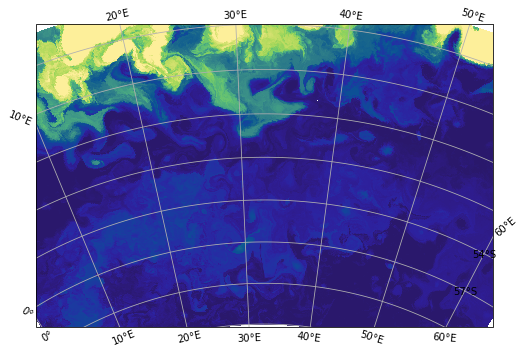

In [22]:
fig = plt.figure(figsize=(6*3,6*4))
fig.set_tight_layout(True)

ax = fig.add_subplot(2, 2, 1, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
ax.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())

ax.gridlines(draw_labels=True)

plt.pcolormesh(XC, YC,
    ds_SO_small.SSS.isel(time=-2500), vmin=33.8, vmax=35.2, cmap=cm.haline ,transform=ccrs.PlateCarree())


/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


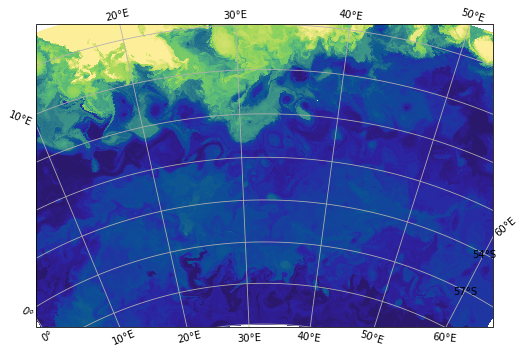

In [63]:
fig = plt.figure(figsize=(6*3,6*4))
fig.set_tight_layout(True)

ax = fig.add_subplot(2, 2, 1, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
ax.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())

ax.gridlines(draw_labels=True)

plt.pcolormesh(XC, YC,
ds_SO.SSS.isel(time=-1), vmin=33.8, vmax=35.1, cmap=cm.haline ,transform=ccrs.PlateCarree())


/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


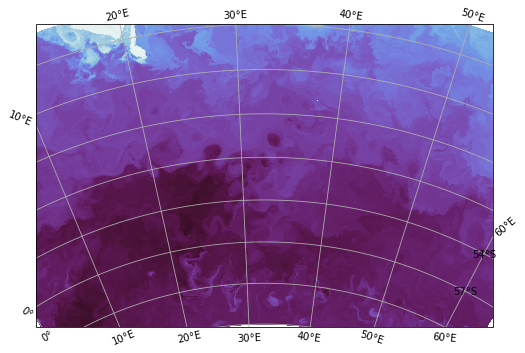

In [67]:
fig = plt.figure(figsize=(6*3,6*4))
fig.set_tight_layout(True)

ax = fig.add_subplot(2, 2, 1, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
ax.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())

ax.gridlines(draw_labels=True)

plt.pcolormesh(XC, YC,
ds_SO.SSD.isel(time=-1), vmin=1026.1, vmax=1027.5, cmap=cm.dense ,transform=ccrs.PlateCarree())


/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


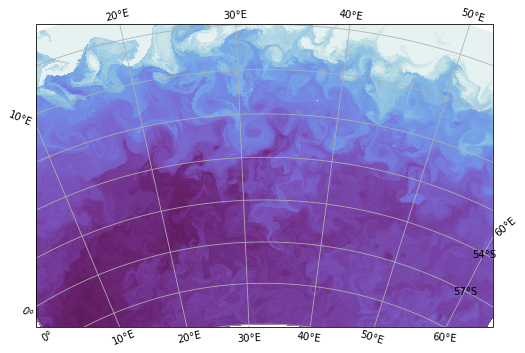

In [69]:
fig = plt.figure(figsize=(6*3,6*4))
fig.set_tight_layout(True)

ax = fig.add_subplot(2, 2, 1, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
ax.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())

ax.gridlines(draw_labels=True)

plt.pcolormesh(XC, YC,
ds_SO.SSD.isel(time=-4500), vmin=1025.9, vmax=1027.5, cmap=cm.dense ,transform=ccrs.PlateCarree())


/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


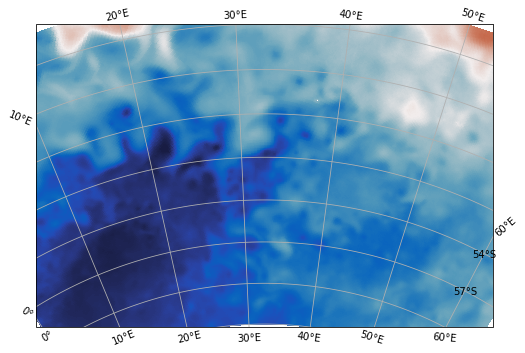

In [70]:
fig = plt.figure(figsize=(6*3,6*4))
fig.set_tight_layout(True)

ax = fig.add_subplot(2, 2, 1, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
ax.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())

ax.gridlines(draw_labels=True)

plt.pcolormesh(XC, YC,
ds_SO.Eta.isel(time=-4500), vmin=-2, vmax=2, cmap=cm.balance ,transform=ccrs.PlateCarree())


/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


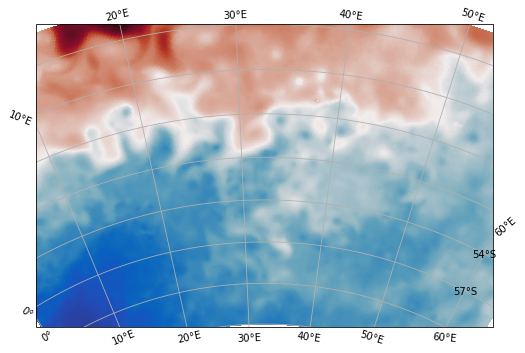

In [71]:
fig = plt.figure(figsize=(6*3,6*4))
fig.set_tight_layout(True)

ax = fig.add_subplot(2, 2, 1, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
ax.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())

ax.gridlines(draw_labels=True)

plt.pcolormesh(XC, YC,
ds_SO.Eta.isel(time=-4506), vmin=-2, vmax=2, cmap=cm.balance ,transform=ccrs.PlateCarree())


In [53]:
def custom_plotfunc(ds_sogos, fig, tt, framedim="time"):
    
    ds_sogos = ds_sogos.isel(i=slice(0,-1,4),j=slice(0,-1,4))
    XC = ds_sogos.XC
    YC = ds_sogos.YC 
    
    ax1=fig.add_subplot(2, 2, 1, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
    ax2=fig.add_subplot(2, 2, 2, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
    ax3=fig.add_subplot(2, 2, 3, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
    ax4=fig.add_subplot(2, 2, 4, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
    
    ax1.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())
    #ax1.gridlines(draw_labels=True)
    gl = ax1.gridlines(draw_labels=True, xlocs=[0,10, 20, 30, 40, 50, 60],
            ylocs = [-60, -55, -50, -45], linestyle='--',)
    gl.xlabels_top = False
    p1 = ax1.pcolormesh(XC, YC, ds_sogos.SST.isel(time=tt), cmap=cm.thermal, transform=ccrs.PlateCarree(),
                        vmin=-2, vmax=15)
    
    cbar1 = fig.colorbar(p1 , ax=ax1)
    cbar1.ax.set_ylabel('Temp')
    #ax1.set_aspect(1.25)
    ax1.set_title(str((ds_sogos.time.isel(time=tt)).dt.strftime("%-H, %b %d, %y").values))

    ax2.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())
    #ax2.gridlines(draw_labels=True)
    gl = ax2.gridlines(draw_labels=True, xlocs=[0,10, 20, 30, 40, 50, 60],
            ylocs = [-60, -55, -50, -45], linestyle='--',)
    gl.xlabels_top = False
    p2 = ax2.pcolormesh(XC, YC, ds_sogos.SSS.isel(time=tt), cmap=cm.haline, transform=ccrs.PlateCarree(),
                       vmin=33.8, vmax=35.3)
        
    cbar2 = fig.colorbar(p2 , ax=ax2)
    cbar2.ax.set_ylabel('Salt')
    #ax2.set_aspect(1.25)
    ax2.set_title(str((ds_sogos.time.isel(time=tt)).dt.season.values))

    ax3.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())
    #ax3.gridlines(draw_labels=True)
    gl = ax3.gridlines(draw_labels=True, xlocs=[0,10, 20, 30, 40, 50, 60],
            ylocs = [-60, -55, -50, -45], linestyle='--',)
    gl.xlabels_top = False
    p3 = ax3.pcolormesh(XC, YC, ds_sogos.SSD.isel(time=tt), cmap=cm.dense, transform=ccrs.PlateCarree(),
                       vmin=1025.9, vmax=1027.35)
    
    cbar3 = fig.colorbar(p3 , ax=ax3)
    cbar3.ax.set_ylabel('Density')
    #ax3.set_aspect(1.25)
    #ax3.set_title(str((ds_sogos.time.isel(time=tt)).dt.strftime("%b %d, %y").values))

    ax4.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())
    #ax4.gridlines(draw_labels=True)
    gl = ax4.gridlines(draw_labels=True, xlocs=[0,10, 20, 30, 40, 50, 60],
            ylocs = [-60, -55, -50, -45], linestyle='--',)
    gl.xlabels_top = False
    p4 = ax4.pcolormesh(XC, YC, ds_sogos.Eta.isel(time=tt), cmap=cm.balance, transform=ccrs.PlateCarree(),
                       vmin=-1.7, vmax=1.3)
        
    cbar4 = fig.colorbar(p4 , ax=ax4)
    cbar4.ax.set_ylabel('SSH')
    #ax4.set_aspect(1.25)
#    ax4.set_title(str((ds_sogos.time.isel(time=tt)).dt.season.values))
    
    fig.tight_layout()


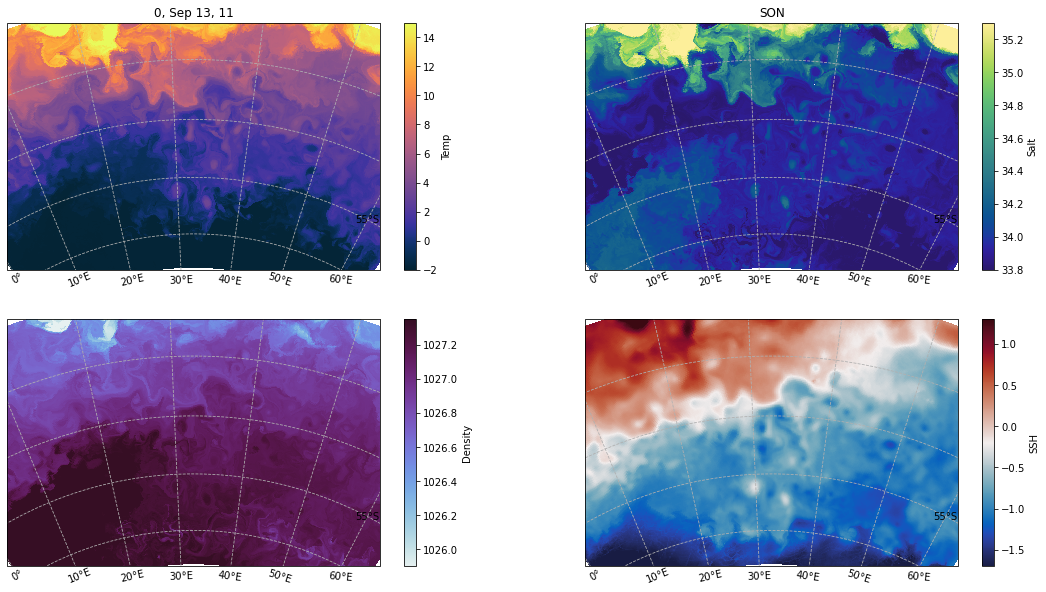

In [70]:
fig = plt.figure(figsize=(19,10))
custom_plotfunc(ds_SO, fig, 0)

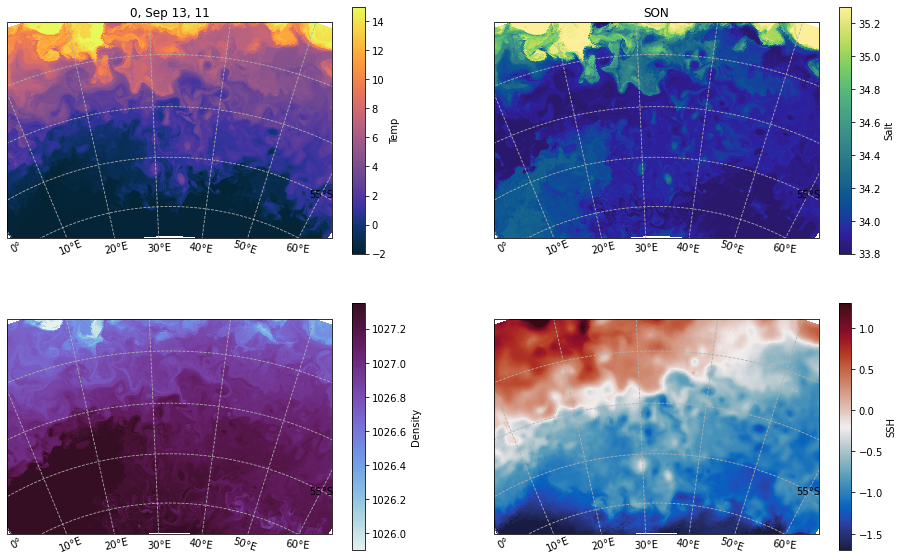

In [61]:
fig = plt.figure(figsize=(16,10))
custom_plotfunc(ds_SO, fig, 0)

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
ds_SO = ds_SO.chunk({'time':1, 'i':3120, 'j':1912})

In [19]:
def custom_plotfunc(ds_sogos, fig, tt):
    
    ds_sogos = ds_sogos.isel(i=slice(0,-1,4),j=slice(0,-1,4))
    XC = ds_sogos.XC
    YC = ds_sogos.YC 
    
    ax1=fig.add_subplot(2, 2, 1, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
    ax2=fig.add_subplot(2, 2, 2, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
    ax3=fig.add_subplot(2, 2, 3, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
    ax4=fig.add_subplot(2, 2, 4, projection=ccrs.SouthPolarStereo(central_longitude=32.5))
    
    ax1.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())
    #ax1.gridlines(draw_labels=True)
    gl = ax1.gridlines(draw_labels=True, xlocs=[0,10, 20, 30, 40, 50, 60],
            ylocs = [-60, -55, -50, -45], linestyle='--', linewidth=0.7)
    gl.xlabels_top = False
    p1 = ax1.pcolormesh(XC, YC, ds_sogos.SST.isel(time=tt), cmap=cm.thermal, transform=ccrs.PlateCarree(),
                        vmin=-2, vmax=15)
    
    cbar1 = fig.colorbar(p1 , ax=ax1)
    cbar1.ax.set_ylabel('Temp')
    #ax1.set_aspect(1.25)
    ax1.set_title(str((ds_sogos.time.isel(time=tt)).dt.strftime("%-H, %b %d, %y").values))

    ax2.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())
    #ax2.gridlines(draw_labels=True)
    gl = ax2.gridlines(draw_labels=True, xlocs=[0,10, 20, 30, 40, 50, 60],
            ylocs = [-60, -55, -50, -45], linestyle='--', linewidth=0.7)
    gl.xlabels_top = False
    p2 = ax2.pcolormesh(XC, YC, ds_sogos.SSS.isel(time=tt), cmap=cm.haline, transform=ccrs.PlateCarree(),
                       vmin=33.8, vmax=35.3)
        
    cbar2 = fig.colorbar(p2 , ax=ax2)
    cbar2.ax.set_ylabel('Salt')
    #ax2.set_aspect(1.25)
    ax2.set_title(str((ds_sogos.time.isel(time=tt)).dt.season.values))

    ax3.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())
    #ax3.gridlines(draw_labels=True)
    gl = ax3.gridlines(draw_labels=True, xlocs=[0,10, 20, 30, 40, 50, 60],
            ylocs = [-60, -55, -50, -45], linestyle='--', linewidth=0.7)
    gl.xlabels_top = False
    p3 = ax3.pcolormesh(XC, YC, ds_sogos.SSD.isel(time=tt), cmap=cm.dense, transform=ccrs.PlateCarree(),
                       vmin=1025.9, vmax=1027.35)
    
    cbar3 = fig.colorbar(p3 , ax=ax3)
    cbar3.ax.set_ylabel('Density')
    #ax3.set_aspect(1.25)
    #ax3.set_title(str((ds_sogos.time.isel(time=tt)).dt.strftime("%b %d, %y").values))

    ax4.set_extent([12, 53, -61.5, -42], ccrs.PlateCarree())
    #ax4.gridlines(draw_labels=True)
    gl = ax4.gridlines(draw_labels=True, xlocs=[0,10, 20, 30, 40, 50, 60],
            ylocs = [-60, -55, -50, -45], linestyle='--', linewidth=0.7)
    gl.xlabels_top = False
    p4 = ax4.pcolormesh(XC, YC, ds_sogos.Eta.isel(time=tt), cmap=cm.balance, transform=ccrs.PlateCarree(),
                       vmin=-1.7, vmax=1.3)
        
    cbar4 = fig.colorbar(p4 , ax=ax4)
    cbar4.ax.set_ylabel('SSH')
    #ax4.set_aspect(1.25)
#    ax4.set_title(str((ds_sogos.time.isel(time=tt)).dt.season.values))
    
    fig.tight_layout()


In [20]:
mov_custom = Movie(ds_SO.isel(time=slice(0,-1,4)), # passing data array that will never be used by custom plotfunc
                   plotfunc=custom_plotfunc, 
                   input_check=False)

In [21]:
mov_custom.save('movie_SO/movie_SO_alias.mp4'
                , overwrite_existing=True, remove_frames=False,
               verbose=True, start_frame=1121)

movie_SO/movie_SO_alias.mp4
ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.1

### What went wrong with parallelization? 
- There is a check that breaks if a dataset is passed instead of data array. Got around this by doing a call to a global variable in the function. 
- Unsure how to set up dask on the cloud. Would either just result in notebook crashing, or if the extra keywords were used then would output some of the frames and not othere and would just sit and keep waiting.


In [ ]:
mov_custom.save('movie_SO/movie_SO_para.mp4',
                overwrite_existing=True, 
                remove_frames=False,
                parallel=True, parallel_compute_kwargs=dict(scheduler="processes", num_workers=8),
                verbose=True)

In [111]:
mov_custom = Movie(ds_SO.chunk({'time':1}).isel(time=slice(4800,4825)), 
                   custom_plotfunc, input_check=False)

In [112]:
mov_custom.save('movie_SO/movie_SO3.mp4'
                , overwrite_existing=True, remove_frames=False,
               verbose=True)

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavforma

In [113]:
mov_custom = Movie(ds_SO.chunk({'time':1}).isel(time=slice(7200,7225)), 
                   custom_plotfunc, input_check=False)

In [114]:
mov_custom.save('movie_SO/movie_SO4.mp4'
                , overwrite_existing=True, remove_frames=False,
               verbose=True)

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavforma

In [16]:
def custom_plotfunc(ds_sogos, fig, tt):
    
    ds_sogos = ds_sogos.isel(i=slice(0,-1,4),j=slice(0,-1,4))
    XC = ds_sogos.XC
    YC = ds_sogos.YC 
    
    ax = fig.subplots(2, 2)

    ax1= ax[0,0]
    ax2= ax[0,1]
    ax3= ax[1,0]
    ax4= ax[1,1]

    p1 = ax1.pcolormesh(XC, YC, ds_sogos.SST.isel(time=tt), cmap=cm.thermal,
                        vmin=24.5, vmax=30.5)
    
    cbar1 = fig.colorbar(p1 , ax=ax1)
    cbar1.ax.set_ylabel('Temp')
    ax1.set_aspect(1.25)
    ax1.set_title(str((ds_sogos.time.isel(time=tt)).dt.strftime("%-H, %b %d, %y").values))

    p2 = ax2.pcolormesh(XC, YC, ds_sogos.SSS.isel(time=tt), cmap=cm.haline,
                       vmin=29, vmax=36.8)
        
    cbar2 = fig.colorbar(p2 , ax=ax2)
    cbar2.ax.set_ylabel('Salt')
    ax2.set_aspect(1.25)
    ax2.set_title(str((ds_sogos.time.isel(time=tt)).dt.season.values))

    p3 = ax3.pcolormesh(XC, YC, ds_sogos.SSD.isel(time=tt), cmap=cm.dense,
                       vmin=1017, vmax=1025)
    
    cbar3 = fig.colorbar(p3 , ax=ax3)
    cbar3.ax.set_ylabel('Density')
    ax3.set_aspect(1.25)
    #ax3.set_title(str((ds_sogos.time.isel(time=tt)).dt.strftime("%b %d, %y").values))

    p4 = ax4.pcolormesh(XC, YC, ds_sogos.Eta.isel(time=tt), cmap=cm.balance,
                       vmin=-2, vmax=2)
        
    cbar4 = fig.colorbar(p4 , ax=ax4)
    cbar4.ax.set_ylabel('SSH')
    ax4.set_aspect(1.25)
#    ax4.set_title(str((ds_sogos.time.isel(time=tt)).dt.season.values))
    
    fig.tight_layout()


In [ ]:
2+2

In [ ]:
mov_custom.save('movie_IO/movie_IO.mp4'
                ,progress=True,remove_frames=False, overwrite_existing=True,
               remove_movie=False, start_frame=4514)

movie_IO/movie_IO.mp4


## Movie of surface kinematics

In [12]:
KE = 0.5*(grid.interp(ds.U,'X',boundary='extend')**2 + grid.interp(ds.V,'Y',boundary='extend')**2) 

zeta = (-grid.diff(ds.U * coords.dxC, 'Y', boundary='extend') + grid.diff(ds.V * coords.dyC, 'X', boundary='extend'))/coords.rAz
zeta = grid.interp(grid.interp(zeta, 'X', boundary='extend'), 'Y', boundary='extend')

strain1 = (grid.diff(ds.U * coords.dyG, 'X', boundary='extend') - grid.diff(ds.V * coords.dxG, 'Y',boundary='extend')) / coords.rA
strain2 = (grid.diff(ds.U * coords.dxC, 'Y', boundary='extend') + grid.diff(ds.V * coords.dyC, 'X', boundary='extend'))/coords.rAz
strain2 = grid.interp(grid.interp(strain2, 'X', boundary='extend'), 'Y', boundary='extend')
strain = (strain1**2 + strain2**2)**0.5

gradD = (grid.interp(grid.diff(ds.SSD,'X',boundary='extend')/coords.dxC, 'X', boundary='extend')**2 +
         grid.interp(grid.diff(ds.SSD,'Y',boundary='extend')/coords.dyC, 'Y', boundary='extend')**2)**0.5

In [13]:
zeta_sogos = zeta.where(sel_XC & sel_YC, drop=True)
strain_sogos = strain.where(sel_XC & sel_YC, drop=True)
gradD_sogos = gradD.where(sel_XC & sel_YC, drop=True)
KE_sogos = KE.where(sel_XC & sel_YC, drop=True)
SSD_sogos = ds.SSD.where(sel_XC & sel_YC, drop=True)

In [14]:
f = 2*(2*np.pi/24/3600)*np.sin(-55*np.pi/360)

ds_kinem_sogos = xr.merge([zeta_sogos.rename('Vorticity')/f,
                           strain_sogos.rename('Strain')/(-f), 
                           gradD_sogos.rename('rho_grad'),
                           KE_sogos.rename('KE'),
                          SSD_sogos])
# f=2*omega*sin(theta)


In [15]:
def custom_plotfunc2(ds_kinem_sogos, fig, tt):
    
    ds_kinem_sogos = ds_kinem_sogos.isel(i=slice(0,-1,1),j=slice(0,-1,1))

    XC = ds_kinem_sogos.XC
    YC = ds_kinem_sogos.YC 

    ax = fig.subplots(2, 2)

    ax1= ax[0,0]
    ax2= ax[0,1]
    ax3= ax[1,0]
    ax4= ax[1,1]

    p1 = ax1.pcolormesh(XC, YC, ds_kinem_sogos.KE.isel(time=tt), cmap=cm.speed_r, vmin=0, vmax=0.8)
    ax1.contour(XC, YC, ds_kinem_sogos.SSD.isel(time=tt), levels=[1027.1], colors='k',linewidths=1)
    ax1.plot(glid659.longitude, glid659.latitude,color='white', linewidth=2)
    cbar1 = fig.colorbar(p1 , ax=ax1)
    cbar1.ax.set_ylabel('KE (m/s)')
    ax1.set_aspect(1.25)
    ax1.set_title(str((ds_kinem_sogos.time.isel(time=tt)).dt.strftime("%b %d, %y").values))

    p2 = ax2.pcolormesh(XC, YC, ds_kinem_sogos.Vorticity.isel(time=tt), cmap=cm.curl, vmin=-1, vmax=1)
    ax2.contour(XC, YC, ds_kinem_sogos.SSD.isel(time=tt), levels=[1027.1], colors='k',linewidths=1)
    ax2.plot(glid659.longitude, glid659.latitude,color='white', linewidth=2)
    cbar2 = fig.colorbar(p2 , ax=ax2)
    cbar2.ax.set_ylabel('Vorticity/f')
    ax2.set_aspect(1.25)
    ax2.set_title(str((ds_kinem_sogos.time.isel(time=tt)).dt.season.values))

    p3 = ax3.pcolormesh(XC, YC, ds_kinem_sogos.Strain.isel(time=tt), cmap=cm.amp, vmin=0, vmax=1)
    ax3.contour(XC, YC, ds_kinem_sogos.SSD.isel(time=tt), levels=[1027.1], colors='k',linewidths=1)
    ax3.plot(glid659.longitude, glid659.latitude,color='white', linewidth=2)
    cbar3 = fig.colorbar(p3, ax=ax3)
    cbar3.ax.set_ylabel('Strain/f')
    ax3.set_aspect(1.25)

    p4 = ax4.pcolormesh(XC, YC, ds_kinem_sogos.rho_grad.isel(time=tt), cmap=cm.ice, vmin=0.1e-5, vmax= 3.5e-5)
    ax4.contour(XC, YC, ds_kinem_sogos.SSD.isel(time=tt), levels=[1027.1], colors='k',linewidths=1)
    ax4.plot(glid659.longitude, glid659.latitude,color='white', linewidth=2)
    cbar4 = fig.colorbar(p4, ax=ax4)
    cbar4.ax.set_ylabel(r'$|\nabla \rho|$')
    ax4.set_aspect(1.25)

    fig.tight_layout()

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
mov_custom_2 = Movie(ds_kinem_sogos.isel(time=slice(0,-1,24)), 
                   custom_plotfunc2, 
                   input_check=False)

In [18]:
mov_custom_2.save('movie_KZSG/movie_KZSG.mp4'
                ,progress=True,remove_frames=False,
                remove_movie=False, start_frame=113)

movie_KZSG/movie_KZSG.mp4



Movie created at movie_KZSG.mp4


In [20]:
import os
dirname = os.path.dirname('movie_KZSG/movie_KZSG.mp4')

In [21]:
dirname

'movie_KZSG'

In [25]:
#from xmovie.core import frame_save

def frame_save(fig, frame, odir=None, frame_pattern="frame_%05d.png", dpi=100):
    fig.savefig(
        os.path.join(odir, frame_pattern % (frame)),
        dpi=dpi,
        facecolor=fig.get_facecolor(),
        transparent=True,
    )
    # I am trying everything to *wipe* this figure, hoping that it could
    # help with the dask glitches I experienced earlier.
    # TBD if this is all needed...how this might affect performance.
    plt.close('all')
    #del fig
    #gc.collect(2)


In [26]:
%matplotlib notebook

In [27]:
for fi in range(67,75):
    fig, ax, pp = mov_custom_2.render_frame(fi)
    frame_save(fig, fi, odir=dirname, frame_pattern=mov_custom_2.frame_pattern, 
               dpi=mov_custom_2.dpi )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>